In [2]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sdv
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# declare file paths for the data we will be working on
file_path_1: str = './phase1/Darknet_reduced_features.csv'
dataPath   : str = './models'


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsdv:\t\t{sdv.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.9.7

    	fastai:		2.5.3
    	matplotlib:	3.5.1
    	numpy:		1.21.5
    	pandas:		1.1.4
    	sdv:		0.13.1
    	sklearn:	1.0.2
    	yellowbrick:	1.3.post1
    


In [19]:
def get_file_path(directory: str):
    '''
        Closure that will return a function. 
        Function will return the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func



def load_data(filePath):
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '/':
        filePathClean: str = filePath[9::]
        pickleDump: str = f'./cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'./cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')


    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
 
    # if not, load data and clean it before caching it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    
    return df



def features_with_bad_values(df: pd.DataFrame, datasetName: str) -> pd.DataFrame:
    '''
        Function will scan the dataframe for features with Inf, NaN, or Zero values.
        Returns a new dataframe describing the distribution of these values in the original dataframe
    '''

    # Inf and NaN values can take different forms so we screen for every one of them
    invalid_values: list = [ np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan', 0 ]
    infs          : list = [ np.inf, 'Infinity', 'inf' ]
    NaNs          : list = [ np.nan, 'NaN', 'nan' ]

    # We will collect stats on the dataset, specifically how many instances of Infs, NaNs, and 0s are present.
    # using a dictionary that will be converted into a (3, 2+88) dataframe
    stats: dict = {
        'Dataset':[ datasetName, datasetName, datasetName ],
        'Value'  :['Inf', 'NaN', 'Zero']
    }

    i = 0
    for col in df.columns:
        
        i += 1
        feature = np.zeros(3)
        
        for value in invalid_values:
            if value in infs:
                j = 0
            elif value in NaNs:
                j = 1
            else:
                j = 2
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                feature[j] += len(indexNames)
                
        stats[col] = feature

    return pd.DataFrame(stats)



def clean_data(df: pd.DataFrame, prune: list) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the columns that match a value in prune 
        Inf values will also be removed from Flow Bytes/s and Flow Packets/s
        once appropriate rows and columns have been removed, we will return
        the dataframe with the appropriate values
    '''

    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)

    return df



class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()

In [12]:
def examine_dataset(job_id: int) -> dict({'File': str, 'Dataset': pd.DataFrame, 'Feature_stats': pd.DataFrame, 'Data_composition': pd.DataFrame}):
    '''
        Function will return a dictionary containing dataframe of the job_id passed in as well as that dataframe's
        feature stats, data composition, and file name.
    '''

    job_id = job_id - 1  # adjusts for indexing while enumerating jobs from 1
    print(f'Dataset {job_id+1}/{len(data_set)}: We now look at {file_set[job_id]}\n\n')


    # Load the dataset
    df: pd.DataFrame = load_data(file_set[job_id])


    # print the data composition
    print(f'''
        File:\t\t\t\t{file_set[job_id]}  
        Job Number:\t\t\t{job_id+1}
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')


    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             file_set[job_id],
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, file_set[job_id]), 
    }
    
    return data_summary


def package_data_for_inspection(df: pd.DataFrame) -> dict({'File': str, 'Dataset': pd.DataFrame, 'Feature_stats': pd.DataFrame, 'Data_composition': pd.DataFrame}):
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             '',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, ''), 
    }
    
    return data_summary


def package_data_for_inspection_with_label(df: pd.DataFrame, label: str) -> dict({'File': str, 'Dataset': pd.DataFrame, 'Feature_stats': pd.DataFrame, 'Data_composition': pd.DataFrame}):
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             f'{label}',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, f'{label}'), 
    }
    
    return data_summary



def check_infs(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of Inf.
    '''

    
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    return inf_df[inf_df[0] != 0]



def check_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of NaN.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    return nan_df[nan_df[1] != 0]



def check_zeros(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T

    return zero_df[zero_df[2] != 0]



def check_zeros_over_threshold(data_summary: dict, threshold: int) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold]



def check_zeros_over_threshold_percentage(data_summary: dict, threshold: float) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with all features with
        a frequency of 0 values greater than the threshold
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    size: int = data_summary['Dataset'].shape[0]
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold*size]


def remove_infs_and_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return the dataset with all inf and nan values removed.
    '''

    df: pd.DataFrame = data_summary['Dataset']
    df = clean_data(df, [])

    return df



def create_new_prune_candidates(zeros_df: pd.DataFrame) -> list:
    '''
        Function creates a list of prune candidates from a dataframe of features with a high frequency of 0 values
    '''

    return list(zeros_df.T.columns)



def intersection_of_prune_candidates(pruneCandidates: list, newPruneCandidates: list) -> list:
    '''
        Function will return a list of features that are in both pruneCandidates and newPruneCandidates
    '''

    return list(set(pruneCandidates).intersection(newPruneCandidates))



def test_infs(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no inf values.
    '''
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    assert inf_df[inf_df[0] != 0].shape[0] == 2, 'Dataset has inf values'
    

    return True



def test_nans(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no NaN values
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    assert nan_df[nan_df[1] != 0].shape[0] == 2, 'Dataset has NaN values'


    return True


   

In [9]:
# This code is used to scale to processing numerous datasets, even though we currently are only looking at one now
data_path_1: str = './phase1/'   
data_set_1: list = [
    'Darknet_reduced_features.csv',
]

data_set: list  = data_set_1
file_path_1      = get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0

In [59]:
def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
        returns the 7-tuple with the following indicies:
        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'


    categorical_features: list = []

    print(df.shape)

    if 'Protocol' in df.columns:
        categorical_features.append("Protocol")
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # Next, we set up, train, and save the deep neural network
    model = tabular_learner(dls, layers=[50, 28], metrics=accuracy, cbs=ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')

    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # A confusion matrix is created to help evaluate the results
    interp = ClassificationInterpretation.from_learner(model)
    interp.plot_confusion_matrix()

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = SklearnWrapper(model)

    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = dep_var
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    viz_data: tuple = (name, wrapped_model, classes, X_train, y_train, X_test, y_test)

    return viz_data


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the values from prune 
        Inf values will also be removed from Flow Bytes/s and Flow Packets/s
        once appropriate rows and columns have been removed, we will return
        the dataframe with the appropriate values
    '''
    # prune: list = [
    #     'Flow ID',
    #     'Src IP',
    #     'Dst IP',
    #     'Src Port',
    #     'Dst Port',
    #     'Timestamp',
    # ]

        # 'Label1'

    # # remove the features in the prune list    
    # for col in prune:
    #     if col in df.columns:
    #         df.drop(columns=[col], inplace=True)
            
    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)


    # Standardize the contents of the Label column
    # df = df.replace( ['DrDoS_DNS'], 'DNS')
    # df = df.replace( ['DrDoS_LDAP'], 'LDAP')
    # df = df.replace( ['DrDoS_MSSQL'], 'MSSQL')
    # df = df.replace( ['DrDoS_NetBIOS'], 'NetBIOS')
    # df = df.replace( ['DrDoS_NTP'], 'NTP')
    # df = df.replace( ['DrDoS_SNMP'], 'SNMP')
    # df = df.replace( ['DrDoS_SSDP'], 'SSDP')
    # df = df.replace( ['DrDoS_UDP'], 'UDP')
    # df = df.replace( ['UDP-lag'], 'UDPLag')

    
    return df



def visualize_confusion_matrix(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.show()


def visualize_roc(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_pr_curve(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(viz_data[1], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_report(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(viz_data[1], classes=viz_data[2], title=viz_data[0], support=True)
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_class_balance(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=viz_data[0])
    visualizer.fit(viz_data[4], viz_data[6])
    visualizer.show()

In [10]:
print(f'We will be cleaning {len(file_set)} files:')
pretty(file_set)

We will be cleaning 1 files:
[   './phase1/Darknet_reduced_features.csv']


In [17]:
dataset_1: dict = examine_dataset(1)


Dataset 1/1: We now look at ./phase1/Darknet_reduced_features.csv


Loading Dataset: ./phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				./phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    


(141481, 78)


epoch,train_loss,valid_loss,accuracy,time
0,0.307129,0.324343,0.896310,00:17
1,0.225769,0.279908,0.905110,00:16
2,0.197444,0.267022,0.910341,00:16
3,0.201534,0.243923,0.913027,00:15
4,0.191424,0.259899,0.914476,00:15
5,0.172246,0.236042,0.918681,00:16
6,0.177126,0.266471,0.917656,00:15
7,0.190475,0.330472,0.927622,00:16
8,0.159899,0.308783,0.921084,00:15
9,0.158459,0.304465,0.917091,00:16


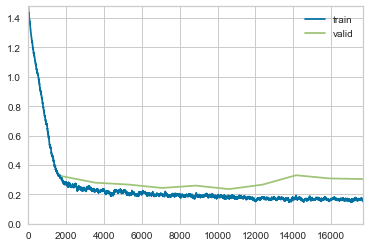

loss 0.3044652044773102: accuracy: 91.71%


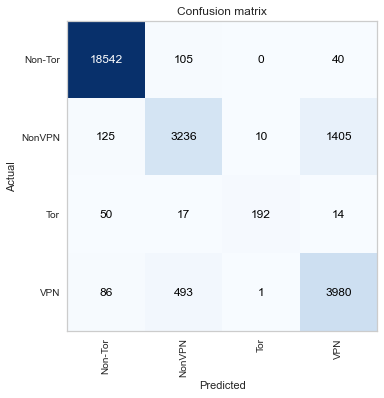

In [61]:
results = run_experiment(df, 'ddos_vs_benign_baseline')

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


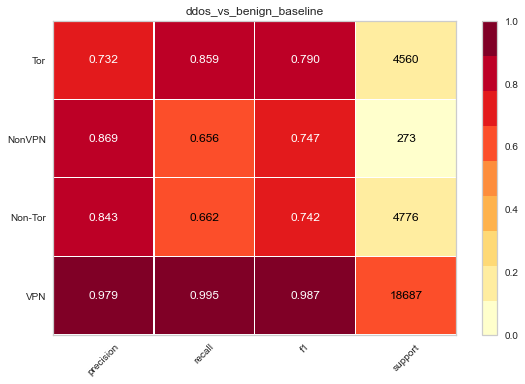

In [56]:
visualize_report(results)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


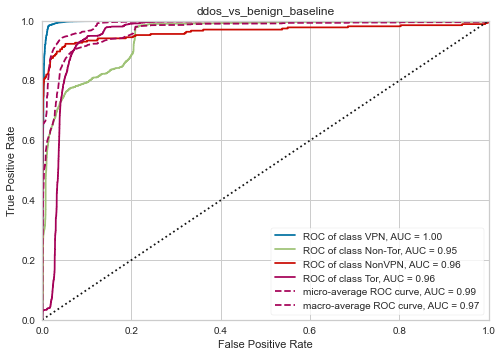

In [57]:
visualize_roc(results)

In [58]:
visualize_pr_curve(results)

AxisError: axis -1 is out of bounds for array of dimension 0